# Определение перспективного тарифа для телеком компании

# Введение

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

Описание тарифов

Тариф «Смарт»

1.	Ежемесячная плата: 550 рублей
2.	Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
o	минута разговора: 3 рубля
o	сообщение: 3 рубля
o	1 Гб интернет-трафика: 200 рублей

Тариф «Ультра»

1.	Ежемесячная плата: 1950 рублей
2.	Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
3.	Стоимость услуг сверх тарифного пакета:
o	минута разговора: 1 рубль
o	сообщение: 1 рубль
o	1 Гб интернет-трафика: 150 рублей


Примечание:
«Мегалайн» всегда округляет секунды до минут, а мегабайты — до гигабайт. Каждый звонок округляется отдельно: даже если он длился всего 1 секунду, будет засчитан как 1 минута.
Для веб-трафика отдельные сессии не считаются. Вместо этого общая сумма за месяц округляется в бо́льшую сторону. Если абонент использует 1025 мегабайт в этом месяце, с него возьмут плату за 2 гигабайта.


**Описание данных**

Таблица users (информация о пользователях):

- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Таблица calls (информация о звонках):

- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Таблица messages (информация о сообщениях):

- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Таблица internet (информация об интернет-сессиях):

- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Таблица tariffs (информация о тарифах):

- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)


## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
import pandas as pd
import numpy as np
import math
import datetime
import scipy.stats as st
import matplotlib.pyplot as plt
calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv').drop(['Unnamed: 0'],axis = 1)
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

In [2]:
# Поочередно изучим информацию о датасетах
calls.info()
calls

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000
...,...,...,...,...
202602,1499_215,2018-12-26,0.76,1499
202603,1499_216,2018-10-18,18.83,1499
202604,1499_217,2018-11-10,10.81,1499
202605,1499_218,2018-10-06,4.27,1499


In [3]:
#Посмотрим датасет с информацией об используемом интернете
internet.info()
internet

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            149396 non-null  object 
 1   mb_used       149396 non-null  float64
 2   session_date  149396 non-null  object 
 3   user_id       149396 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
149391,1499_152,318.90,2018-10-03,1499
149392,1499_153,490.13,2018-12-14,1499
149393,1499_154,0.00,2018-10-27,1499
149394,1499_155,1246.32,2018-11-26,1499


In [4]:
#Посмотрим датасет с информацией об смс
messages.info()
messages

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000
...,...,...,...
123031,1499_179,2018-12-12,1499
123032,1499_180,2018-09-28,1499
123033,1499_181,2018-09-27,1499
123034,1499_182,2018-11-15,1499


In [5]:
#Посмотрим датасет с информацией о тарифах
tariffs.info()
tariffs

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   messages_included      2 non-null      int64 
 1   mb_per_month_included  2 non-null      int64 
 2   minutes_included       2 non-null      int64 
 3   rub_monthly_fee        2 non-null      int64 
 4   rub_per_gb             2 non-null      int64 
 5   rub_per_message        2 non-null      int64 
 6   rub_per_minute         2 non-null      int64 
 7   tariff_name            2 non-null      object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [6]:
#Посмотрим датасет с информацией об используемом интернете
users.info()
users

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra
...,...,...,...,...,...,...,...,...
495,1495,65,NaN,Иркутск,Авксентий,Фокин,2018-08-28,ultra
496,1496,36,NaN,Вологда,Трифон,Блохин,2018-01-27,smart
497,1497,32,NaN,Челябинск,Каролина,Агеева,2018-10-09,smart
498,1498,68,2018-10-25,Владикавказ,Всеволод,Акимчин,2018-07-19,smart


Получили несколько таблиц, необходимо объеденить таблицы в одну по заданию и для удобства. 
Таблица юзеров имеет пропуски в столбце "churn_date", так как churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных). Поэтому просто оставим это как есть.

In [7]:
#Проверим число дубликатов:
print("Число дубликатов в calls:", calls.duplicated().sum())
print("Число дубликатов в internet:", internet.duplicated().sum())
print("Число дубликатов в messages:", messages.duplicated().sum())
print("Число дубликатов в tariffs:", tariffs.duplicated().sum())

Число дубликатов в calls: 0
Число дубликатов в internet: 0
Число дубликатов в messages: 0
Число дубликатов в tariffs: 0


In [8]:
print("Число строк в датафрейме users:", users.shape[0])
print("Число уникальных пользователей:", users['user_id'].count())
print("Число дубликатов:", users.duplicated().sum())

Число строк в датафрейме users: 500
Число уникальных пользователей: 500
Число дубликатов: 0


In [9]:
print('Количество звонков с длительностью, равной нулю:', calls[calls['duration']==0]['duration'].count())

Количество звонков с длительностью, равной нулю: 39613


In [10]:
print('Кол-во дубликатов =', users.loc[:,['age', 'churn_date', 'city', 'first_name', \
                                          'last_name', 'reg_date', 'tariff']].duplicated().sum())

Кол-во дубликатов = 0


## Шаг 2. Подготовьте данные

**Приведите данные к нужным типам;
Найдите и исправьте ошибки в данных, если они есть.**


In [11]:
#Приводим данные к нужным типам
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

<AxesSubplot:ylabel='Frequency'>

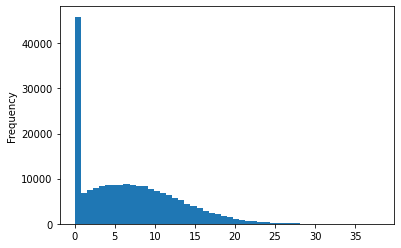

In [12]:
#Рассмотрим подробнее таблицу calls
#Посмотрим на гистограмму распределения длительности звонков:
calls['duration'].plot(kind='hist', bins=50)

In [13]:
#Можем быть, все звонки длительностью до 1 минуты, имеют длительность "0"?
calls.query('0 < duration < 0.5')

,id,call_date,duration,user_id
55,1000_55,2018-09-19,0.31,1000
65,1000_65,2018-10-28,0.34,1000
97,1000_97,2018-10-26,0.33,1000
122,1000_122,2018-10-07,0.13,1000
135,1000_135,2018-10-25,0.02,1000
...,...,...,...,...
202318,1498_111,2018-10-17,0.46,1498
202322,1498_115,2018-10-02,0.49,1498
202438,1499_51,2018-10-08,0.47,1499
202452,1499_65,2018-11-30,0.20,1499


In [14]:
#Есть звонки и околонулевой длительности.
#«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.
#Округляем в большую сторону до минуты все звонки при помощи np.ceil:
calls['duration'] = np.ceil(calls['duration'])
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
2,1000_2,2018-06-11,3.0,1000
3,1000_3,2018-09-21,14.0,1000
4,1000_4,2018-12-15,6.0,1000


<AxesSubplot:ylabel='Frequency'>

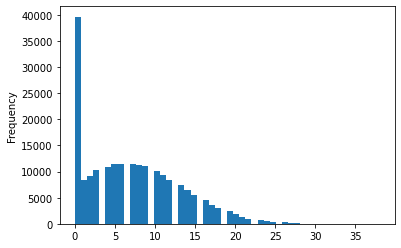

In [15]:
#Повторно посмотрим на гистограмму распределения длительности звонков:
calls['duration'].plot(kind='hist', bins=50)

In [16]:
#Посмотрим на "нулевые" звонки:
calls.query('duration == 0.0')

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.0,1000
1,1000_1,2018-08-17,0.0,1000
5,1000_5,2018-11-02,0.0,1000
6,1000_6,2018-10-18,0.0,1000
9,1000_9,2018-08-15,0.0,1000
...,...,...,...,...
202590,1499_203,2018-12-03,0.0,1499
202592,1499_205,2018-10-13,0.0,1499
202593,1499_206,2018-12-26,0.0,1499
202594,1499_207,2018-10-28,0.0,1499


In [17]:
#Проверим, к одному ли тарифу они относятся. Может быть, на каком-то тарифе так некорректно округлились данные, которые должны были округлиться в большую сторону (до 1 минуты):
map_to_fill_tariff = dict(pd.Series(users['tariff'].values, index=users['user_id']))
calls['Тариф'] = calls['user_id'].map(map_to_fill_tariff)
calls['Тариф'].value_counts()

smart    130315
ultra     72292
Name: Тариф, dtype: int64

по каждому из тарифов есть нулевые звонки. Предполагаю, что это несостоявшиеся звонки. Нулевая их длительность вызвана прерыванием связи или случаями, когда у другого абонента было "занято" и поэтому происходил моментальный сброс вызова. 

In [18]:
#тк они не расходуют лимиты минут и вообще не принимают участия в формировании конечной выручки, может стоит вовсе удалить эти строки?
calls['duration'] = calls['duration'].replace(0, np.NaN)
calls = calls.dropna()

<AxesSubplot:ylabel='Frequency'>

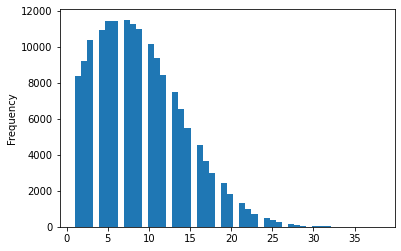

In [19]:
calls['duration'].plot(kind='hist', bins=50)

In [20]:
#Рассмотрим подробнее таблицу internet
internet.head()

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000


In [21]:
#«Мегалайн» всегда округляет вверх значения минут и мегабайт. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута.
#Округляем в большую сторону до мегабайта весь трафик по каждой сессии при помощи np.ceil:
#internet['mb_used'] = np.ceil(internet['mb_used'])
#internet.head()

<AxesSubplot:ylabel='Frequency'>

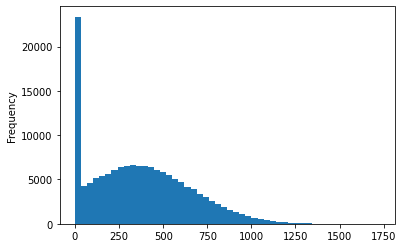

In [22]:
#Посмотрим на гистограмму распределения использования интернет-трафика в сессиях:
internet['mb_used'].plot(kind='hist', bins=50)

In [23]:
#Посмотрим на строки с нулевым трафиком:
internet.query('mb_used == 0')

,id,mb_used,session_date,user_id
11,1000_11,0.0,2018-08-28,1000
38,1000_38,0.0,2018-11-27,1000
46,1000_46,0.0,2018-06-30,1000
67,1000_67,0.0,2018-06-16,1000
72,1000_72,0.0,2018-06-15,1000
...,...,...,...,...
149380,1499_141,0.0,2018-12-11,1499
149381,1499_142,0.0,2018-11-01,1499
149383,1499_144,0.0,2018-11-27,1499
149386,1499_147,0.0,2018-10-21,1499


In [24]:
#Это сессии, когда подключение к интернету было включено, но в дальнейшем ни одной операции произведено не было 
#(например, случаи, когда появляется и сразу пропадает связь).
#Эти строки можно тоже исключить из датафрейма:
internet['mb_used'] = internet['mb_used'].replace(0, np.NaN)
internet = internet.dropna()

<AxesSubplot:ylabel='Frequency'>

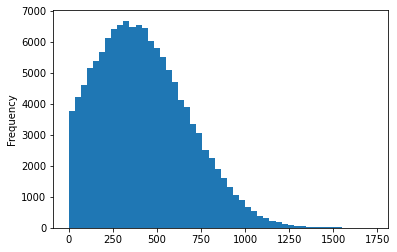

In [25]:
internet['mb_used'].plot(kind='hist', bins=50)

In [26]:
# добавим столбцы со значением месяца
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
messages['month'] = pd.DatetimeIndex(messages['message_date']).month
internet['month'] = pd.DatetimeIndex(internet['session_date']).month
display(calls.sample(3), messages.sample(3), internet.sample(3))

/tmp/ipykernel_189/954118506.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calls['month'] = pd.DatetimeIndex(calls['call_date']).month
/tmp/ipykernel_189/954118506.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  internet['month'] = pd.DatetimeIndex(internet['session_date']).month


,id,call_date,duration,user_id,Тариф,month
28288,1070_163,2018-10-22,3.0,1070,smart,10
172888,1427_252,2018-07-21,1.0,1427,smart,7
55289,1140_44,2018-12-31,4.0,1140,smart,12


,id,message_date,user_id,month
37165,1161_57,2018-08-10,1161,8
96229,1395_216,2018-03-29,1395,3
118666,1482_228,2018-06-07,1482,6


,id,mb_used,session_date,user_id,month
45585,1157_97,550.68,2018-08-19,1157,8
38723,1135_203,220.02,2018-11-28,1135,11
148265,1496_213,771.57,2018-08-22,1496,8


### Необходимо посчитать следующие данные:
Посчитайте для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам;
- количество отправленных сообщений по месяцам;
- объем израсходованного интернет-трафика по месяцам;
- помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).


In [27]:
#Создадим 3 таблицы: new_calls, new_messages, new_internet, сгруппированные по user_id и month, в которых будет 
#записан результат выполнения первых трех заданий
abonent = pd.DataFrame()

new_calls = calls.groupby(['user_id', 'month'])['duration'].agg(['count','sum']).reset_index()
new_calls.columns = ['user_id', 'month', 'calls', 'minutes']

new_messages = messages.groupby(['user_id', 'month'])['id'].count().reset_index()
new_messages.columns = ['user_id', 'month', 'messages']

new_internet = internet.groupby(['user_id', 'month'])['mb_used'].sum().reset_index()
new_internet.columns = ['user_id', 'month', 'mb']

display(new_calls.head())
display(new_messages.head())
display(new_internet.head())

,user_id,month,calls,minutes
0,1000,5,17,159.0
1,1000,6,28,172.0
2,1000,7,41,340.0
3,1000,8,42,408.0
4,1000,9,46,466.0


,user_id,month,messages
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57


,user_id,month,mb
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91


In [28]:
#Тепрерь создадим из 3 таблиц new_calls, new_messages, new_internet главную таблицу abonents

all_abonents = users.loc[:,['user_id', 'city', 'tariff']]

# abonents = pd.merge(abonents, ab_calls, how='inner', on='user_id')
abonents = pd.merge(new_calls, new_messages, how='outer', on=['user_id', 'month'])
abonents = pd.merge(abonents, new_internet, how='outer', on=['user_id', 'month'])
abonents = pd.merge(abonents, all_abonents, how='outer', on=['user_id'])
abonents

,user_id,month,calls,minutes,messages,mb,city,tariff
0,1000,5.0,17.0,159.0,22.0,2253.49,Краснодар,ultra
1,1000,6.0,28.0,172.0,60.0,23233.77,Краснодар,ultra
2,1000,7.0,41.0,340.0,75.0,14003.64,Краснодар,ultra
3,1000,8.0,42.0,408.0,81.0,14055.93,Краснодар,ultra
4,1000,9.0,46.0,466.0,57.0,14568.91,Краснодар,ultra
...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,NaN,21.0,19559.44,Санкт-Петербург,smart
3212,1489,11.0,NaN,NaN,20.0,17491.56,Санкт-Петербург,smart
3213,1489,12.0,NaN,NaN,35.0,17322.51,Санкт-Петербург,smart
3214,1128,NaN,NaN,NaN,NaN,NaN,Волжский,ultra


In [29]:
# Проверим все ли абоненты на месте, должно быть 500
abonents['user_id'].nunique()

500

In [30]:
#Чтобы посчитать выручку income за месяц надо избавиться от пропусков NaN. Логично заполнить их нулями. 
#Там где не было звонков - 0, минут - 0, не было СМС - 0, не было интернет-трафика - 0 МБ
#Посмотрим сколько у нас пропусков в таблице abonents
abonents.isna().sum()

user_id       0
month         2
calls        48
minutes      48
messages    499
mb           15
city          0
tariff        0
dtype: int64

In [31]:
display(abonents[abonents['month'].isna()])

,user_id,month,calls,minutes,messages,mb,city,tariff
3214,1128,NaN,NaN,NaN,NaN,NaN,Волжский,ultra
3215,1371,NaN,NaN,NaN,NaN,NaN,Омск,smart


Оказывается есть пропуски в столбце month. Это 2 абонента подключенных недавно или в конце года - поэтому ставим их в столбце с месяцем 12 и будем считать, что раз подключился, то выручка будет равна абонентской плате

In [32]:
abonents.loc[:,['calls', 'minutes', 'messages', 'mb']] = abonents.loc[:,['calls', 'minutes', 'messages', 'mb']].fillna(0)
abonents.loc[:,['month']] = abonents.loc[:,['month']].fillna(12)
abonents.isna().sum()

user_id     0
month       0
calls       0
minutes     0
messages    0
mb          0
city        0
tariff      0
dtype: int64

In [33]:
#Теперь пора добавить новый столбец выручка - income в таблицу abonents. Напишем функцию income_month, которая 
#принимает строку, и возвращает значение выручки
#(вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика; 
#остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану)
print(tariffs.loc[1,'rub_per_message'])
tariffs

1


,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [34]:
def revenue_month(revenue_month):
        
    if revenue_month['tariff'] == 'smart':
        
        inc_calls = (revenue_month['minutes'] - tariffs.loc[0,'minutes_included']) * tariffs.loc[0,'rub_per_minute']
        if inc_calls < 0 :
            inc_calls = 0
        
        inc_messages = (revenue_month['messages'] - tariffs.loc[0,'messages_included']) * tariffs.loc[0,'rub_per_message']
        if inc_messages < 0 :
            inc_messages = 0
        
        inc_mb  = np.ceil((revenue_month['mb'] - tariffs.loc[0,'mb_per_month_included'])/1024) * tariffs.loc[0,'rub_per_gb'] 
        if inc_mb < 0 :
            inc_mb = 0
             
        inc = inc_calls + inc_messages + inc_mb + tariffs.loc[0,'rub_monthly_fee']
        
    elif revenue_month['tariff'] == 'ultra':
        
        inc_calls = (revenue_month['minutes'] - tariffs.loc[1,'minutes_included']) * tariffs.loc[1,'rub_per_minute']
        if inc_calls < 0 :
            inc_calls = 0
        
        inc_messages = (revenue_month['messages'] - tariffs.loc[1,'messages_included']) * tariffs.loc[1,'rub_per_message']
        if inc_messages < 0 :
            inc_messages = 0
        
        inc_mb  = ((revenue_month['mb'] - tariffs.loc[1,'mb_per_month_included'])/1024) * tariffs.loc[1,'rub_per_gb'] 
        if inc_mb < 0 :
            inc_mb = 0
             
        inc = inc_calls + inc_messages + inc_mb + tariffs.loc[1,'rub_monthly_fee']
        
    else:
        print('Неизвестный тариф')
        
    
    return inc

abonents['revenue'] = abonents.apply(revenue_month, axis=1)
abonents

,user_id,month,calls,minutes,messages,mb,city,tariff,revenue
0,1000,5.0,17.0,159.0,22.0,2253.49,Краснодар,ultra,1950.0
1,1000,6.0,28.0,172.0,60.0,23233.77,Краснодар,ultra,1950.0
2,1000,7.0,41.0,340.0,75.0,14003.64,Краснодар,ultra,1950.0
3,1000,8.0,42.0,408.0,81.0,14055.93,Краснодар,ultra,1950.0
4,1000,9.0,46.0,466.0,57.0,14568.91,Краснодар,ultra,1950.0
...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,0.0,0.0,21.0,19559.44,Санкт-Петербург,smart,1550.0
3212,1489,11.0,0.0,0.0,20.0,17491.56,Санкт-Петербург,smart,1150.0
3213,1489,12.0,0.0,0.0,35.0,17322.51,Санкт-Петербург,smart,950.0
3214,1128,12.0,0.0,0.0,0.0,0.00,Волжский,ultra,1950.0


Создали новую таблицу abonents - в которую сгруппировали данные по каждому абоненту за каждый месяц пользования (попутно были созданы еще 3 вспомогательные таблицы). Заполнили образовавшиеся пропуски. Рассчитали для анализа 4 столбца: minutes - минут/мес, messages - СМС/мес, mb - МБ/мес и revenue - выручка за месяц. Таблица готова для анализа.

In [35]:
#Переведем Мб в Гб
abonents['mb'] = abonents['mb']/1024
abonents.columns = ['user_id', 'month', 'calls', 'minutes', 'messages', 'gb', 'city', 'tariff', 'revenue']
abonents

,user_id,month,calls,minutes,messages,gb,city,tariff,revenue
0,1000,5.0,17.0,159.0,22.0,2.200674,Краснодар,ultra,1950.0
1,1000,6.0,28.0,172.0,60.0,22.689229,Краснодар,ultra,1950.0
2,1000,7.0,41.0,340.0,75.0,13.675430,Краснодар,ultra,1950.0
3,1000,8.0,42.0,408.0,81.0,13.726494,Краснодар,ultra,1950.0
4,1000,9.0,46.0,466.0,57.0,14.227451,Краснодар,ultra,1950.0
...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,0.0,0.0,21.0,19.101016,Санкт-Петербург,smart,1550.0
3212,1489,11.0,0.0,0.0,20.0,17.081602,Санкт-Петербург,smart,1150.0
3213,1489,12.0,0.0,0.0,35.0,16.916514,Санкт-Петербург,smart,950.0
3214,1128,12.0,0.0,0.0,0.0,0.000000,Волжский,ultra,1950.0


In [36]:
abonents['gb'] = np.ceil(abonents['gb'])
abonents

,user_id,month,calls,minutes,messages,gb,city,tariff,revenue
0,1000,5.0,17.0,159.0,22.0,3.0,Краснодар,ultra,1950.0
1,1000,6.0,28.0,172.0,60.0,23.0,Краснодар,ultra,1950.0
2,1000,7.0,41.0,340.0,75.0,14.0,Краснодар,ultra,1950.0
3,1000,8.0,42.0,408.0,81.0,14.0,Краснодар,ultra,1950.0
4,1000,9.0,46.0,466.0,57.0,15.0,Краснодар,ultra,1950.0
...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,0.0,0.0,21.0,20.0,Санкт-Петербург,smart,1550.0
3212,1489,11.0,0.0,0.0,20.0,18.0,Санкт-Петербург,smart,1150.0
3213,1489,12.0,0.0,0.0,35.0,17.0,Санкт-Петербург,smart,950.0
3214,1128,12.0,0.0,0.0,0.0,0.0,Волжский,ultra,1950.0


## Шаг 3. Проанализируйте данные

**Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.**

In [37]:
#Расчитаем общие показатели всех клиентов по месяцам по обоим тарифам
all_clients_month = abonents.groupby(['tariff', 'month'])['minutes', 'messages', 'gb', 'revenue'].sum().reset_index()
all_clients_month

/tmp/ipykernel_189/3756012755.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  all_clients_month = abonents.groupby(['tariff', 'month'])['minutes', 'messages', 'gb', 'revenue'].sum().reset_index()


,tariff,month,minutes,messages,gb,revenue
0,smart,1.0,6931.0,620.0,297.0,24525.000000
1,smart,2.0,17324.0,1397.0,687.0,48001.000000
2,smart,3.0,30034.0,2453.0,1173.0,89676.000000
3,smart,4.0,41119.0,3443.0,1526.0,107866.000000
4,smart,5.0,54618.0,4762.0,2243.0,168849.000000
5,smart,6.0,64885.0,5478.0,2616.0,197459.000000
6,smart,7.0,82079.0,6784.0,3191.0,246014.000000
7,smart,8.0,99045.0,7905.0,3933.0,310340.000000
8,smart,9.0,111439.0,8746.0,4262.0,324986.000000
9,smart,10.0,125284.0,9927.0,4963.0,401267.000000


In [38]:
# для наглядности разобьем all_clients_month на 2 таблице по тарифу
smart_all_clients_month = all_clients_month.query(' tariff=="smart" ')
ultra_all_clients_month = all_clients_month.query(' tariff=="ultra" ').reset_index(drop=True)

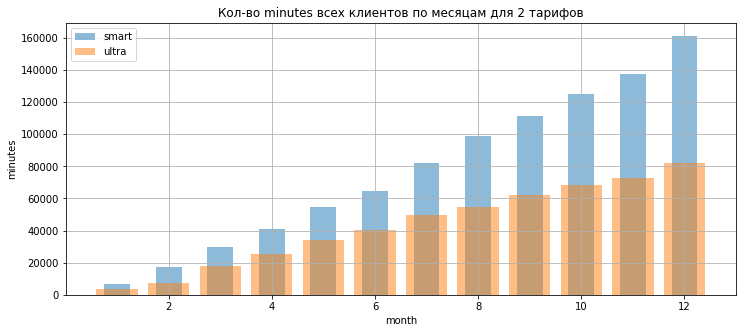

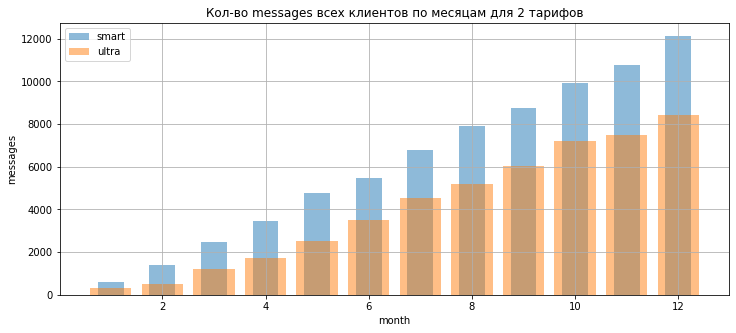

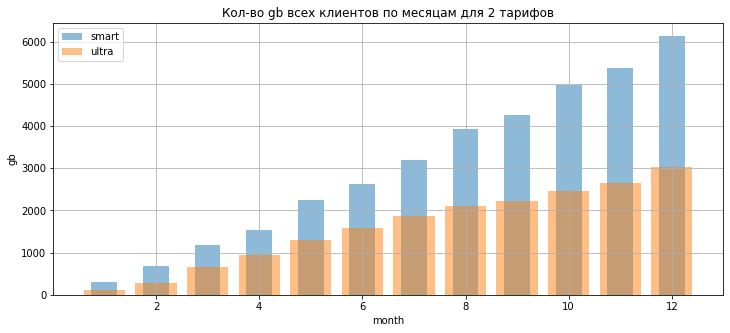

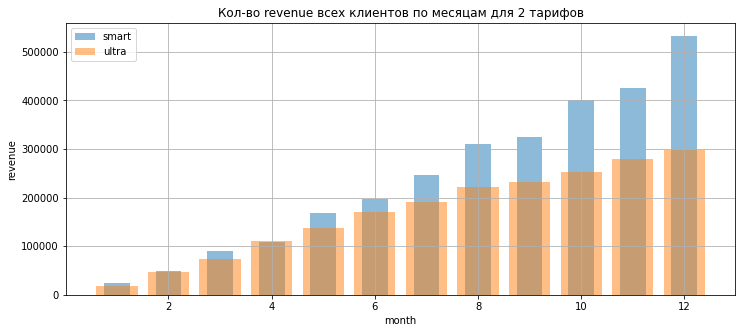

In [39]:
for x in ['minutes', 'messages', 'gb', 'revenue']:
    plt.figure(figsize=(12, 5))
    plt.bar(smart_all_clients_month['month'], smart_all_clients_month[x], label='smart', alpha=0.5, width=0.5)
    plt.bar(ultra_all_clients_month['month'], ultra_all_clients_month[x], label='ultra', alpha=0.5)

    plt.xlabel('month')
    plt.ylabel(x)
    plt.grid()
    plt.title(f'Кол-во {x} всех клиентов по месяцам для 2 тарифов')
    plt.legend()
    plt.show();

In [40]:
users.tariff.value_counts()

smart    351
ultra    149
Name: tariff, dtype: int64

Из графиков видно, что общий расход минут, СМС, Гб всех абонентов тарифа 'smart' больше, чем 'ultra', но и абонентов у 'smart' в 2 раза больше, чем у 'ultra'.

По выручке надо отметить: в первой половине года абоненты обоих тарифов приносят почти одинаковые суммы, а во второй - абоненты smart с каждым месяцем приносят выручки больше, где выручка уже почти в 2 раза больше, чем от тарифа ultra.

По всем графикам видно, что гистограммы постоянно возрастают от меcяца к месяцу - это показывает новый приток абонентов каждый месяц. Поэтому логично будет посчитать усредненные показатели расхода на одного абонента за каждый месяц и уже тогда сравнить тарифы.

In [41]:
#Расчитаем средние(медианные) показатели клиента по месяцам по обоим тарифам 
abonents[['minutes', 'messages', 'gb','revenue']].describe()

,minutes,messages,gb,revenue
count,3216.000000,3216.000000,3216.000000,3216.000000
mean,450.964241,38.257463,17.288246,1525.753073
std,242.096312,36.149684,7.410845,793.099135
min,0.000000,0.000000,0.000000,550.000000
25%,282.000000,9.000000,13.000000,750.000000
50%,443.000000,30.000000,17.000000,1653.500000
75%,589.000000,57.000000,21.000000,1950.000000
max,1673.000000,224.000000,49.000000,6770.000000


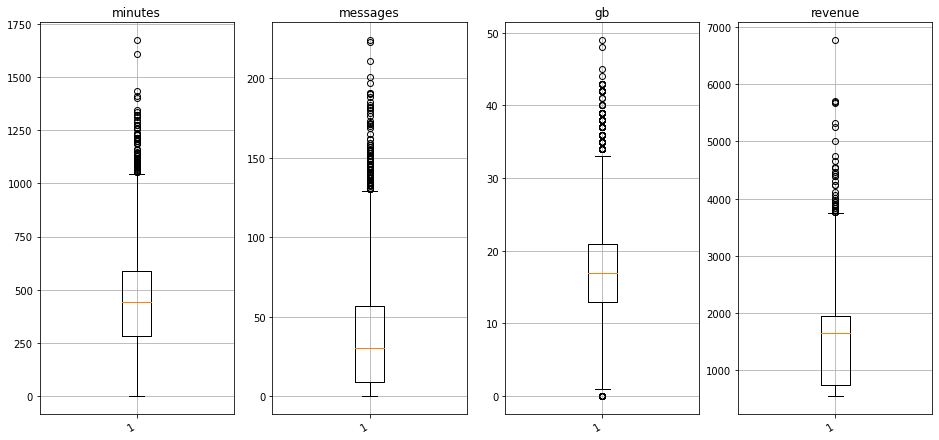

In [42]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(nrows=1, ncols=4, figsize=(16, 8))
p = {ax1:'minutes', ax2:'messages', ax3:'gb', ax4:'revenue'}
for ax in [ax1, ax2, ax3, ax4]:
    ax.boxplot(abonents[p[ax]])
    ax.grid()
    ax.set_title(p[ax])
fig.autofmt_xdate()

Сильных выбросов нет, вполне адекватные числа, поэтому для вычисления усредненных значений можно использовать и среднее и медиану. 

In [43]:
#Сгруппируем и создадим новую таблицу tariffss - с общими данными по тарифам
tariffss = abonents.groupby(['tariff', 'month'])['minutes', 'messages', 'gb','revenue'].mean().reset_index()
tariffss

/tmp/ipykernel_189/1253670303.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tariffss = abonents.groupby(['tariff', 'month'])['minutes', 'messages', 'gb','revenue'].mean().reset_index()


,tariff,month,minutes,messages,gb,revenue
0,smart,1.0,203.852941,18.235294,8.735294,721.323529
1,smart,2.0,298.689655,24.086207,11.844828,827.603448
2,smart,3.0,390.051948,31.857143,15.233766,1164.623377
3,smart,4.0,367.133929,30.741071,13.625000,963.089286
4,smart,5.0,387.361702,33.773050,15.907801,1197.510638
5,smart,6.0,395.640244,33.402439,15.951220,1204.018293
6,smart,7.0,408.353234,33.751244,15.875622,1223.950249
7,smart,8.0,421.468085,33.638298,16.736170,1320.595745
8,smart,9.0,428.611538,33.638462,16.392308,1249.946154
9,smart,10.0,426.136054,33.765306,16.880952,1364.853741


In [44]:
#разделим новую таблицу на две smart и ultra - по каждому тарифу
smart = tariffss.query(' tariff=="smart" ')
ultra = tariffss[tariffss['tariff']=='ultra'].reset_index(drop=True)

In [45]:
smart.head()

,tariff,month,minutes,messages,gb,revenue
0,smart,1.0,203.852941,18.235294,8.735294,721.323529
1,smart,2.0,298.689655,24.086207,11.844828,827.603448
2,smart,3.0,390.051948,31.857143,15.233766,1164.623377
3,smart,4.0,367.133929,30.741071,13.625000,963.089286
4,smart,5.0,387.361702,33.773050,15.907801,1197.510638


In [46]:
ultra.head()

,tariff,month,minutes,messages,gb,revenue
0,ultra,1.0,428.111111,33.777778,13.222222,1950.000000
1,ultra,2.0,297.125000,21.958333,12.000000,1972.664917
2,ultra,3.0,489.648649,32.297297,17.648649,2003.537307
3,ultra,4.0,458.018182,31.563636,16.963636,1995.016593
4,ultra,5.0,510.328358,37.850746,19.373134,2054.477073


In [47]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


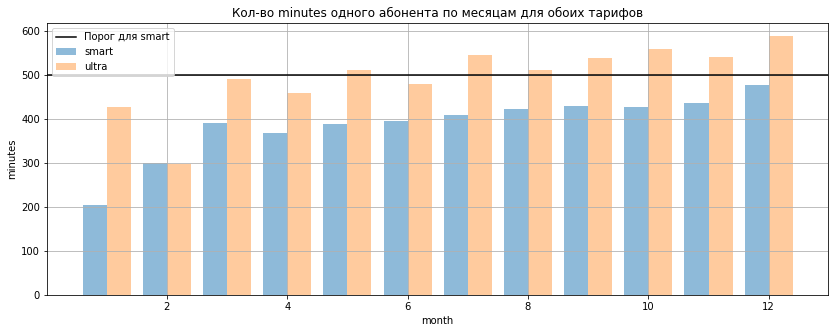

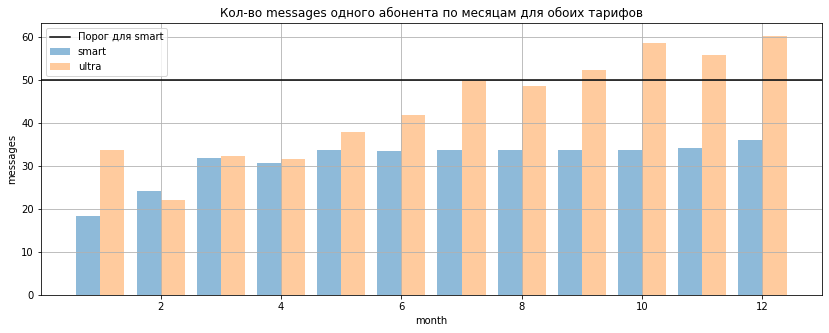

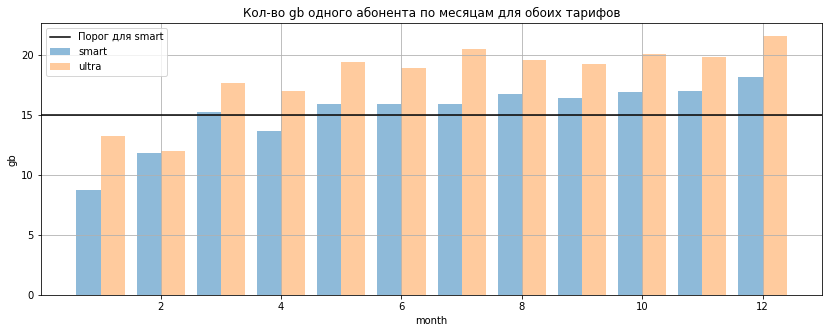

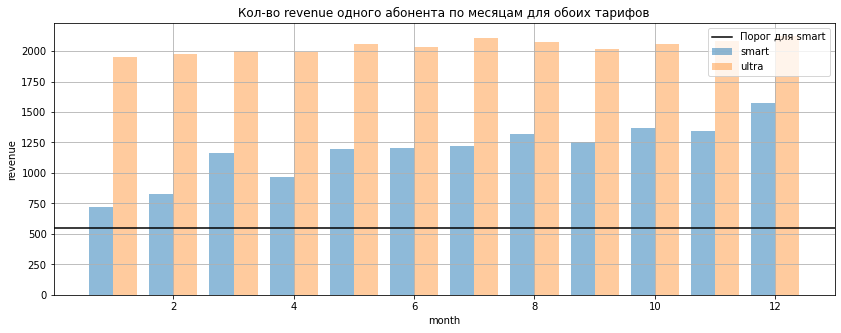

In [48]:
#Нарисуем теперь для обоих тарифов усредненные расходы по месяцам для одного абонента

for x in ['minutes', 'messages', 'gb','revenue']:
    plt.figure(figsize=(14, 5))
    plt.bar(smart['month']-0.4/2, smart[x], label='smart', alpha=0.5, width=0.4)
    plt.bar(ultra['month']+0.4/2, ultra[x], label='ultra', alpha=0.4, width=0.4)

# max- пороговое значение в smart, после которого идёт оплата сверх абонентской
    if x == 'minutes':
        max=500
    elif x == 'messages':
        max=50
    elif x == 'gb':
        max=15
    else:
        max=550
        
    plt.axhline(y=max, label='Порог для smart', color='black')  
    plt.xlabel('month')
    plt.ylabel(x)
    plt.grid()
    plt.title(f'Кол-во {x} одного абонента по месяцам для обоих тарифов')
    plt.legend()
    plt.show();

In [49]:
#Рассчитаем усредненные значения за месяц, которые требуются абонентам в обоих тарифах
for x in ['minutes', 'messages', 'gb','revenue']:
    print(f'Кол-во {x}: smart = {round(smart[x].median())} / ultra = {round(ultra[x].median())}')

Кол-во minutes: smart = 402 / ultra = 511
Кол-во messages: smart = 34 / ultra = 45
Кол-во gb: smart = 16 / ultra = 19
Кол-во revenue: smart = 1214 / ultra = 2043


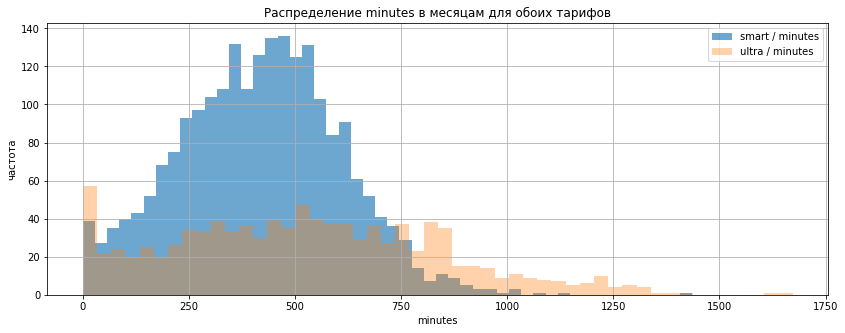

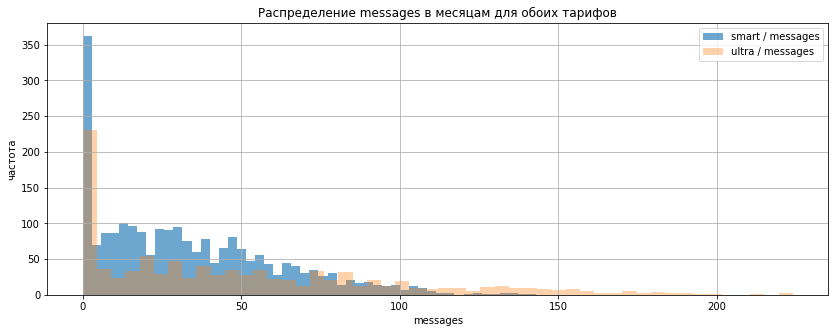

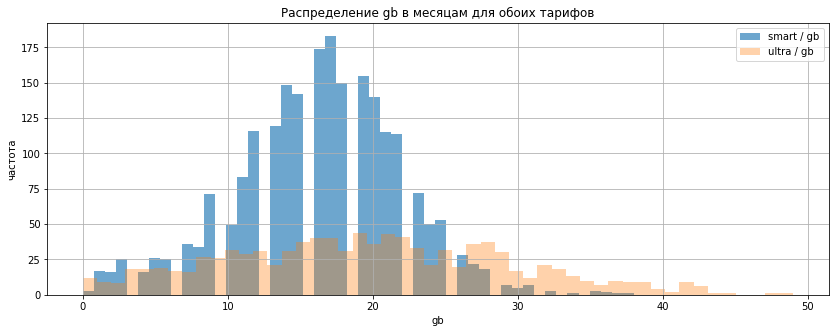

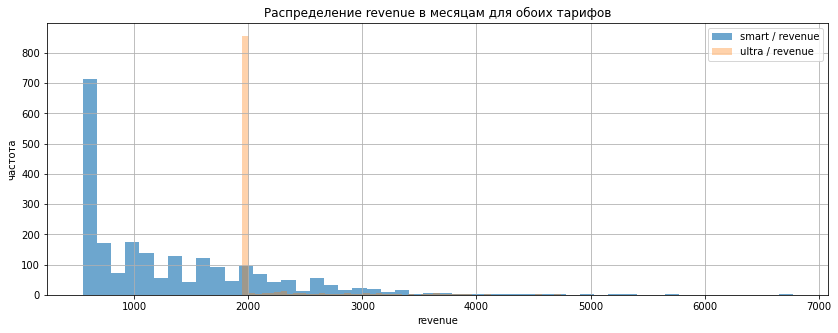

In [50]:
#Распределение абонентов по кол-ву использованых услуг
#Посмотрим на гистограммах частоту распределения клиентов по объему использования услуг
for x in ['minutes', 'messages', 'gb','revenue']:
    plt.figure(figsize=(14, 5))
    plt.hist(abonents.loc[abonents['tariff'] == "smart", x], label='smart / '+x, alpha=0.65, bins = 50)
    plt.hist(abonents.loc[abonents['tariff'] == "ultra", x], label='ultra / '+x, alpha=0.35, bins = 50)
    
    plt.ylabel('частота')
    plt.xlabel(x)
    plt.grid()
    plt.title(f'Распределение {x} в месяцам для обоих тарифов')
    plt.legend()
    plt.show();

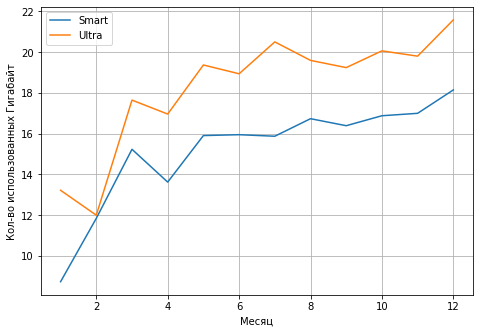

In [51]:
#Сравним графики использованного интернета для тарифов 
analys_data_merge_mb_used = abonents.pivot_table(index = ['tariff','month'], values = 'gb', aggfunc = 'mean')
analys_data_merge_mb_used = analys_data_merge_mb_used.reset_index()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.grid()
ax.set_xlabel('Месяц')
ax.set_ylabel('Кол-во использованных Гигабайт')

ax.plot(analys_data_merge_mb_used['month'][0:12], analys_data_merge_mb_used['gb'][0:12], label="Smart")
ax.plot(analys_data_merge_mb_used['month'][12:], analys_data_merge_mb_used['gb'][12:], label="Ultra")

ax.legend()

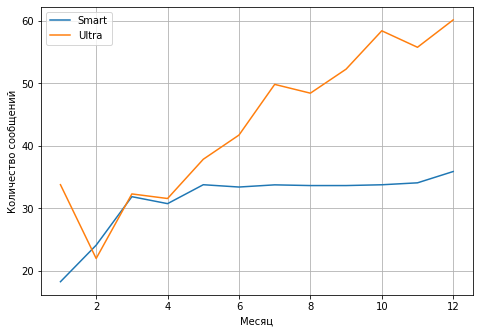

In [52]:
#Сравним графики отправленных сообщений для тарифов
analys_data_messages_used = abonents.pivot_table(index = ['tariff','month'], values = 'messages', aggfunc = 'mean')
analys_data_messages_used = analys_data_messages_used.reset_index()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.grid()
ax.set_xlabel('Месяц')
ax.set_ylabel('Количество сообщений')

ax.plot(analys_data_messages_used['month'][0:12], analys_data_messages_used['messages'][0:12], label="Smart")
ax.plot(analys_data_messages_used['month'][12:], analys_data_messages_used['messages'][12:], label="Ultra")

ax.legend()


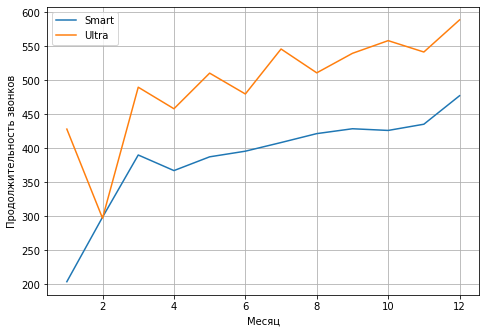

In [53]:
#Сравним графики длительности звонков для тарифов 
analys_data_calls_used = abonents.pivot_table(index = ['tariff','month'], values = 'minutes', aggfunc = 'mean')
analys_data_calls_used = analys_data_calls_used.reset_index()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.grid()
ax.set_xlabel('Месяц')
ax.set_ylabel('Продолжительность звонков')

ax.plot(analys_data_calls_used['month'][0:12], analys_data_calls_used['minutes'][0:12], label="Smart")
ax.plot(analys_data_calls_used['month'][12:], analys_data_calls_used['minutes'][12:], label="Ultra")

ax.legend()

По графикам видно следующее: пользователи тарифа Ultra активнее используют свой тариф по каждому из пунктов (звонки, интернет и сообщения), а пользователи тарифа Smart больше выходят за рамки ограничений, бесплатного интернета т.е переплачивают за дополнительлное использование, возможно, абонентская плата меньше, но переплата за услуги больше.

In [54]:
#Найдем дисперсию, ско и среднее значение по продолжительности звонков разных тарифов
ultra = abonents.loc[abonents['tariff'] == 'ultra']
smart = abonents.loc[abonents['tariff'] == 'smart']

variance_estimate_ultra_dur = np.var(ultra['minutes'], ddof=1)
variance_estimate_smart_dur = np.var(smart['minutes'], ddof=1)

(print ('Дисперсия тарифа ultra:', round(variance_estimate_ultra_dur, 2),
  '\nCреднее значение ultra:', round(ultra['minutes'].mean(), 2),
  '\nСтандартное отклонение ultra:', round(np.sqrt(variance_estimate_ultra_dur), 2), '\n'))

(print ('Дисперсия тарифа smart:', round(variance_estimate_smart_dur, 2),
  '\nCреднее значение smart:', round(smart['minutes'].mean(), 2),
  '\nСтандартное отклонение smart:', round(np.sqrt(variance_estimate_smart_dur), 2), '\n'))

Дисперсия тарифа ultra: 101052.49 
Cреднее значение ultra: 526.09 
Стандартное отклонение ultra: 317.89 

Дисперсия тарифа smart: 36281.39 
Cреднее значение smart: 417.75 
Стандартное отклонение smart: 190.48 



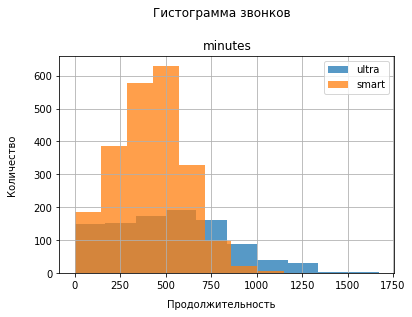

In [55]:
fig, axes = plt.subplots(sharex=True, sharey=True)

ultra.hist('minutes', alpha=0.75, ax=axes, label='ultra', bins = 10)
smart.hist('minutes', alpha=0.75, ax=axes, label = 'smart', bins = 10)
plt.legend(loc='upper right')


plt.suptitle('Гистограмма звонков', x=0.5, y=1.05, ha='center')
fig.text(0.5, 0.004, 'Продолжительность', ha='center')
fig.text(0.004, 0.5, 'Количество', va='center', rotation='vertical')
plt.show()

Распределение тарифа smart имеет вид нормального распределения, с средним значением в районе 60 минут, что подтверждают рассчеты и сам график, исходя из этого можно утверждать, что пользователи данного тарифа используют связь довольно редко (60 +- 25 (стандартное отклонение))с возможностью бесплатных звонков 500. Пользователи тарифа ultra также не используют потенциал тарифа в безлимитных звонках, среднее значение находится в диапазоне 47 минут +- 43 с возможностью бесплатных звонков 3000. Распределение могло бы быть похоже на нормальное, но мы видим что большая часть звонков происходит в районе от 0 до 10 минут.

In [56]:
#Найдем дисперсию, ско и среднее значение по количеству сообщений
variance_estimate_ultra_message = np.var(ultra['messages'], ddof=1)
variance_estimate_smart_message = np.var(smart['messages'], ddof=1)

(print ('Дисперсия тарифа ultra:', round(variance_estimate_ultra_message, 2),
  '\nCреднее значение:', round(ultra['messages'].mean(), 2),
  '\nСтандартное отклонение:', round(np.sqrt(variance_estimate_ultra_message), 2), '\n'))

(print ('Дисперсия тарифа smart:', round(variance_estimate_smart_message, 2),
  '\nCреднее значение:', round(smart['messages'].mean(), 2),
  '\nСтандартное отклонение:', round(np.sqrt(variance_estimate_smart_message), 2), '\n'))

Дисперсия тарифа ultra: 2285.42 
Cреднее значение: 49.31 
Стандартное отклонение: 47.81 

Дисперсия тарифа smart: 796.96 
Cреднее значение: 33.37 
Стандартное отклонение: 28.23 



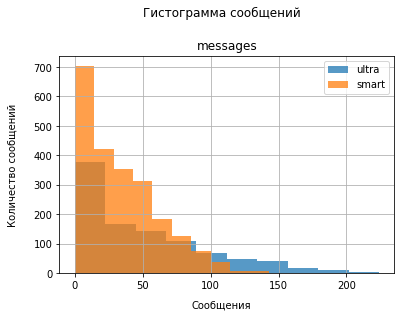

In [57]:
fig, axes = plt.subplots(sharex=True, sharey=True)

ultra.hist('messages', alpha=0.75, ax=axes, label='ultra', bins = 10)
smart.hist('messages', alpha=0.75, ax=axes, label = 'smart', bins = 10)
plt.legend(loc='upper right')

plt.suptitle('Гистограмма сообщений', x=0.5, y=1.05, ha='center')
fig.text(0.5, 0.004, 'Сообщения', ha='center')
fig.text(0.004, 0.5, 'Количество сообщений', va='center', rotation='vertical')

plt.show()

Для пользователей тарифа ultra количество бесплатных сообщений установлено в значение 1000, по данному распределению можно сказать, что большая часть пользователей отправляет от 0 до 10 сообщений, и их предел заканчивается у границы с значением в 200, т.е пользователи так же не используют полностью потенциал тарифа, что нельзя сказать о пользователях тарифа smart, с них компания получает большую выгоду т.к количество бесплатных сообщений составляет 50, а пользователи данного тарифа отправляют сообщения сверх лимита, что является несомненным плюсом в рекомендации использования тарифа smart для компании.

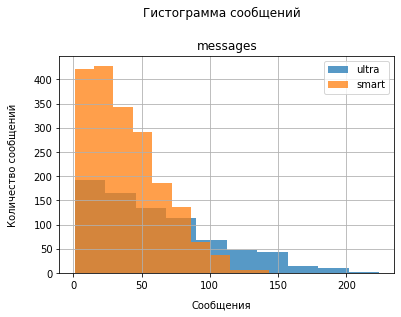

In [58]:
fig, axes = plt.subplots(sharex=True, sharey=True)

ultra.query('messages > 0').hist('messages', alpha=0.75, ax=axes, label='ultra', bins = 10)
smart.query('messages > 0').hist('messages', alpha=0.75, ax=axes, label = 'smart', bins = 10)
plt.legend(loc='upper right')

plt.suptitle('Гистограмма сообщений', x=0.5, y=1.05, ha='center')
fig.text(0.5, 0.004, 'Сообщения', ha='center')
fig.text(0.004, 0.5, 'Количество сообщений', va='center', rotation='vertical')

plt.show()

In [59]:
# Процент пользователей с переплатой за сообщения по каждому тарифу за сообщения
print('Процент переплат ultra:', len(ultra.loc[ultra['messages'] > 1000]) / len(ultra))
print('Процент переплат smart:', round(len(smart.loc[smart['messages'] > 50]) / len(smart) * 100, 2), '%')

Процент переплат ultra: 0.0
Процент переплат smart: 25.29 %


In [60]:
#Найдем дисперсию, ско и среднее значение по количеству использованных гигабайт
variance_estimate_ultra_mb = np.var(ultra['gb'], ddof=1)
variance_estimate_smart_mb = np.var(smart['gb'], ddof=1)

(print ('Дисперсия тарифа ultra:', round(variance_estimate_ultra_message, 2),
  '\nCреднее значение:', round(ultra['gb'].mean(), 2),
  '\nСтандартное отклонение:', round(np.sqrt(variance_estimate_ultra_message), 2), '\n'))

(print ('Дисперсия тарифа smart:', round(variance_estimate_smart_message, 2),
  '\nCреднее значение:', round(smart['gb'].mean(), 2),
  '\nСтандартное отклонение:', round(np.sqrt(variance_estimate_smart_message), 2), '\n'))

Дисперсия тарифа ultra: 2285.42 
Cреднее значение: 19.47 
Стандартное отклонение: 47.81 

Дисперсия тарифа smart: 796.96 
Cреднее значение: 16.32 
Стандартное отклонение: 28.23 



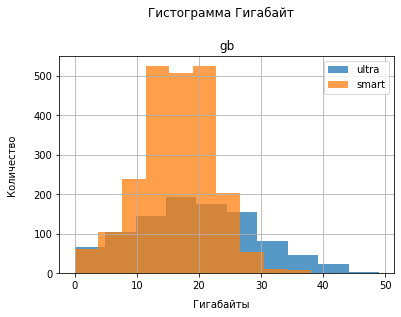

In [61]:
fig, axes = plt.subplots(sharex=True, sharey=True)

ultra.hist('gb', alpha=0.75, ax=axes, label='ultra', bins = 10)
smart.hist('gb', alpha=0.75, ax=axes, label = 'smart', bins = 10)
plt.legend(loc='upper right')

plt.suptitle('Гистограмма Гигабайт', x=0.5, y=1.05, ha='center')
fig.text(0.5, 0.004, 'Гигабайты', ha='center')
fig.text(0.004, 0.5, 'Количество', va='center', rotation='vertical')

plt.show()

Распределение тарифа smart имеет вид нормального распределения. Исходя из данного распределения можно утверждать, что более выгодной рекомндацией для компании будет продажа тарифа smart, т.к пользователи имеют ограничение в 15Гб и видно, что больше половины пользователей используют интернет в диапазоне от 15Гб до +-27Гб, что является существенной переплатой за интернет трафик. Что касается тарифа ultra, у которого ограничение в 30Гб, по графику видно, что только небольшая часть пользователей переплачивают за него.

In [62]:
# Процент пользователей с переплатой за сообщения по каждому тарифу за интернет
print('Процент переплат ultra:', round(len(ultra.loc[ultra['gb'] > 30]) / len(ultra) * 100, 2), '%')
print('Процент переплат smart:', round(len(smart.loc[smart['gb'] > 15]) / len(smart) * 100, 2), '%')

Процент переплат ultra: 13.59 %
Процент переплат smart: 58.48 %


In [63]:
(
    abonents
         .pivot_table(index = 'tariff', values = ['minutes', 'messages', 'gb','revenue'], 
                                                                  aggfunc = ['mean', 'median', 'std', 'var'])
         .round()
        .transpose()
)

tariff              smart     ultra
mean   gb            16.0      19.0
       messages      33.0      49.0
       minutes      418.0     526.0
       revenue     1290.0    2060.0
median gb            17.0      19.0
       messages      28.0      38.0
       minutes      422.0     518.0
       revenue     1021.0    1950.0
std    gb             6.0      10.0
       messages      28.0      48.0
       minutes      190.0     318.0
       revenue      818.0     355.0
var    gb            33.0      97.0
       messages     797.0    2285.0
       minutes    36281.0  101052.0
       revenue   669731.0  125825.0

Исходя из полученных результатов и рассмотренных гистограмм делаем вывод, что наиболее выгодной продажей является тариф smart - меньше абонентская плата - но большое количество пользователей переплачивают за сообщения и интернет.

## Шаг 4. Проверьте гипотезы

- средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
- средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### Первая гипотеза

H0  — средняя выручка пользователей тарифа «Ультра» равна средней выручке пользователей тарифа «Смарт».
H1 — средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.
α=1%

In [64]:
ultra = abonents.query('tariff == "ultra"')['revenue']
smart = abonents.query('tariff == "smart"')['revenue']

alpha = .01

results = st.ttest_ind(
    ultra, 
    smart, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.6156508226843834e-252
Отвергаем нулевую гипотезу


In [65]:
abonents.pivot_table(index='tariff', values='revenue', aggfunc='median')

,revenue
tariff,
smart,1021.0
ultra,1950.0


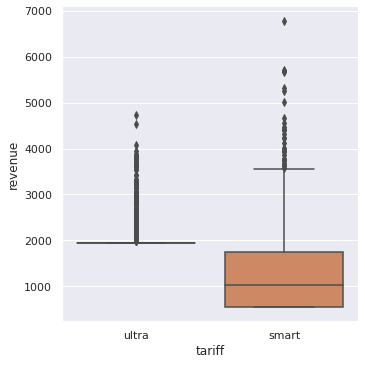

In [66]:
import seaborn as sns
sns.set(color_codes=True)
snsplot = sns.catplot(x="tariff", y='revenue', kind="box", data=abonents, orient='v')

Средние значения выручки по тарифам различаются почти в 2 раза. Если у пользователя подключен тариф smart с абонентской платой в 500 рублей, то он скорее всего по итогам месяца заплатит гораздо больше из-за нехватки услуг в рамках тарифного пакета.
В заключение можно подтвердить с уверенностью 99%, что доходы "Мегалайна" с пользователя по тарифу ultra действительно отличаются по сравнению с доходами от тарифа smart.

### Вторая гипотеза

H0  — средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.
H1 — средняя выручка пользователей из Москвы отличается от средней выручке пользователей из других регионов.
α=1%

In [67]:
moscow = abonents.query('city == "Москва"')['revenue']
regions = abonents.query('city != "Москва"')['revenue']

alpha = .01

results = st.ttest_ind(
    moscow, 
    regions, 
    equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.5411182259648013
Не получилось отвергнуть нулевую гипотезу


P-значения используются при проверке истинности нулевых гипотез: чем оно меньше, тем больше вероятность, что мы отклоним нулевую гипотезу. В данном случае р-уровень значимости составил почти 54%, что значительно выше 5% => средняя выручка по Москве статистически значимо не отличается от средней выручки по другим регионам.

In [68]:
def det_region(city):
    if city == 'Москва': return 'Москва'
    else: return 'Другой регион'
    
abonents['region'] = abonents['city'].apply(det_region)
abonents.pivot_table(index='region', values='revenue', aggfunc='median')

,revenue
region,
Другой регион,1583.0
Москва,1750.0


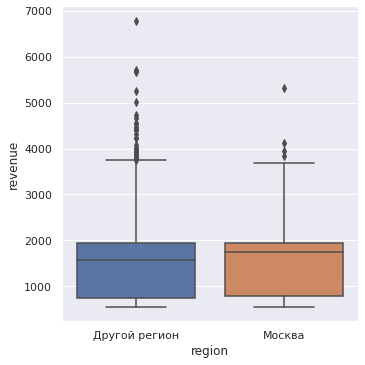

In [69]:
snsplot = sns.catplot(x="region", y='revenue', kind="box", data=abonents, orient='v')

Данный статистический тест не дал возможности опровергунть исходную гипотезу о том, что доходы от пользователей из Москвы и из других регионов равны. Действительно, доходы в Московском регионе практически не отличаются от других населенных пунктов.

Вывод: Таким образом мы принимаем нулевую гипотезу и говорим, что средняя выручка пользователей из Москвы равна выручке пользователей из других регионов. Поэтому утверждение из задания не подтвердилось.

### Сравнение двух тарифов 

In [70]:
abonents.columns

Index(['user_id', 'month', 'calls', 'minutes', 'messages', 'gb', 'city',
       'tariff', 'revenue', 'region'],
      dtype='object')

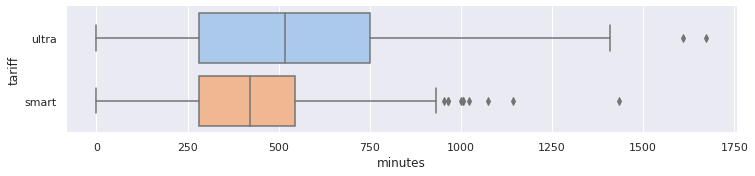

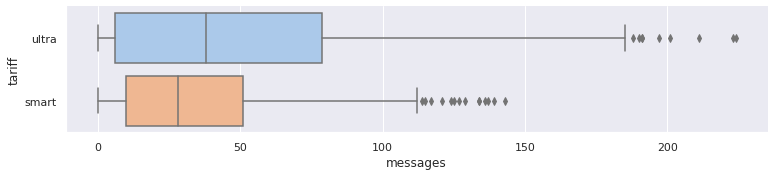

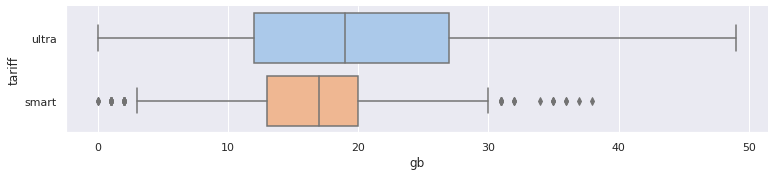

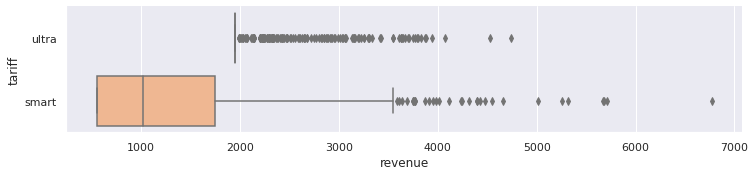

In [71]:
for column in ['minutes', 'messages', 'gb','revenue']:    
    g = sns.catplot(y='tariff', x=column, kind="box", data=abonents, orient='h', palette = 'pastel')
    g.fig.set_figwidth(12)
    g.fig.set_figheight(2)

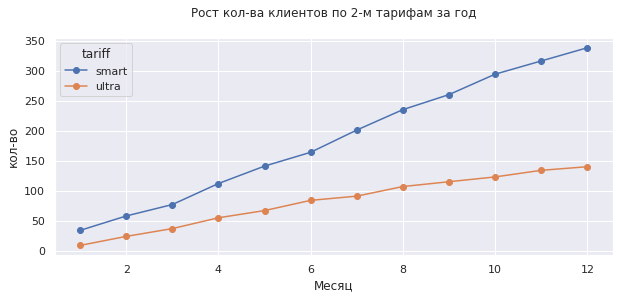

In [72]:
(abonents
 .pivot_table(index='tariff', columns='month', values='user_id', aggfunc='count')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Рост кол-ва клиентов по 2-м тарифам за год'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('кол-во');

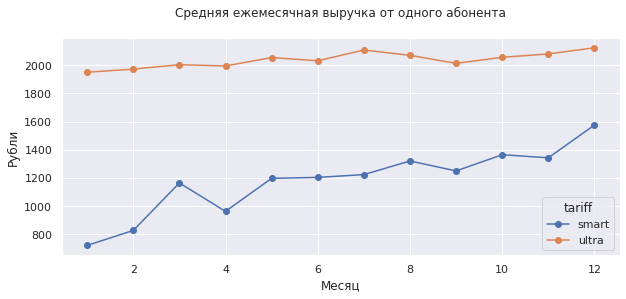

In [73]:
(abonents
 .pivot_table(index='tariff', columns='month', values='revenue', aggfunc='mean')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Средняя ежемесячная выручка от одного абонента'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('Рубли');

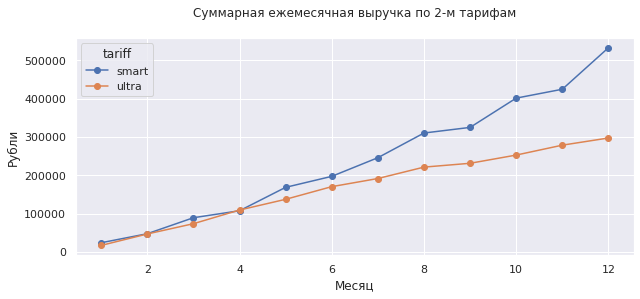

In [74]:
(abonents
 .pivot_table(index='tariff', columns='month', values='revenue', aggfunc='sum')
 .T
 .plot(kind='line', figsize=(10,4),  style = 'o-')
)
plt.title('Суммарная ежемесячная выручка по 2-м тарифам'+ "\n")
plt.xlabel('Месяц')
plt.ylabel('Рубли');

In [75]:
ultra_revenue = abonents.query('tariff =="ultra"')['revenue'].sum()
ultra_abonents = len(abonents.query('tariff =="ultra"'))
smart_revenue = abonents.query('tariff =="smart"')['revenue'].sum()
smart_abonents = len(abonents.query('tariff =="smart"'))
print(f'Выручка тарифа Ультра = {ultra_revenue} {ultra_revenue/149}')
print(f'Выручка тарифа Смарт = {smart_revenue} {smart_revenue/351}')

Выручка тарифа Ультра = 2030920.8837890625 13630.341501940016
Выручка тарифа Смарт = 2875901.0 8193.450142450143


## Шаг 5. Напишите общий вывод

### Вывод:
- Рассмотрены все таблицы, проведен анализ данных и недороботок в них;
- Изменены типы данных, проведена полная проверка соответствующая всем алгоритмам предобработки;
- Добавлены необходимые для анализа расчеты;
- Все таблицы объеденены в одну для удобства работы с данными;
- Построены и проанализированы средние значения по каждому из пунктов (сообщения, мегабайты, звонки);
- Проведена проверка полученных данных из рассчетов при помощи гистограмм;
- Проверены гипотезы и подтверждены выводы.

В процессе анализа было выявлено:
1) В тарифе smart подавляющее большинство абонентов укладываются в лимит. В тарифе ultra пользователи не используют свой пакет услуг в полном объеме. Также можно наблюдать, что расход минут постепенно возрастает в течение года. 

2) СМС - мало популярная услуга (много абонентов которых вообще не пишут СМС или почти не пишут). Абоненты тарифа smart вполне укладываются в лимит 50 СМС, даже абоненты тарифа ultra редко превышают порог в 50 СМС.

3) А вот с интернет-трафиком другая ситуация. Абоненты smart любят посидеть в интернете и частенько привышают лимитв 15 Гб, даже среднее значение выше - 16 Гб.  Подавляющее большинство абонентов расходуют в месяц трафика от 11 до 23 ГБ

4) По выручке можно сказать: что выручка абонентов ultra в подавляющем большинстве случаев ограничивается абонплатой(1950р), а абоненты smart напротив очень часто платят сверх абонплаты.

5) В принципе многие абоненты ultra могли бы перейти на тариф smart и платили бы меньше - если исходить из усредненных значений.

- Была создана таблица stat_df, куда записаны среднее, дисперсия и стандартное отклонение для 4 параметров (минуты разговора, СМС, кол-во интернет-трафика, выручка) по каждому тарифу Смарт и Ультра и по объединенным значениям обоих тарифов

- Проверены две гипотезы:
1) Гипотеза №1, где средняя выручка пользователей тарифов Ультра и Смарт отличается: данная гипотеза может быть подтверждена. Данные из выборок говорят о том, что скорее всего средняя выручка на разных тарифах отличается.
2) Гипотеза №2, где средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов: данная гипотеза не может быть подтверждена, так как данные из выборки говорят о том, что скорее всего средняя выручка по регионам не отличается.

В итоге можно рекомендовать оператору продвигать тариф Смарт. Он приносит больше выручки (это очень весомый фактор для оператора), его абоненты очень часто переплачивают сверх лимита, в отличие от абонентов Ультры, которые очень редко используют весь свой лимит. Также по абонентской плате он более привлекателен для абонентов - а это очень весомый фактор для потенциальных пользователей.